In [1]:
#making the correlation plot between evrery waveform

In [1]:
import ROOT 
import numpy as np
import matplotlib.pyplot as plt
import radiotools.helper
import scipy
import re
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import h5py
import glob 
from scipy import interpolate
import json
import os
import sys
from scipy import stats
from NuRadioReco.utilities import units
from NuRadioReco.detector import detector
from NuRadioMC.utilities import fluxes
from NuRadioMC.utilities.Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
#from my_Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
from NuRadioMC.examples.Sensitivities import E2_fluxes3 as limits
from Get_hdf5_data import get_attr_data, get_shower_data, get_station_data, get_Veff_data, get_event_data, get_nur_data
from Peak_Finding import count_peak, get_noise, save_data_2_csv, read_column_csv, get_peak, make_max_array
import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import NuRadioReco.detector.detector as detector
import NuRadioReco.modules.io.eventReader
import astropy
from NuRadioReco.framework.parameters import stationParameters as stnp
import pandas as pd
from math import isclose
import mplhep as hep
from scipy.signal import find_peaks

PATH = "/home/teikiet/Data/"
##########################################################################
S_ID = [100, 2, 3, 4, 5] #station ID
C_ID = list(range(0,16)) #channel ID
V_pole_channel = list(range(0,8)) #channel ID
H_pole_channel = list(range(8,16)) #channel ID
##########################################################################
E = 18 #energy
detectordescription = "detector/ara2.json" #detector 
##########################################################################


def correlation(channel1, channel2):
    return radiotools.helper.get_normalized_xcorr(channel1,channel2)
def correlation2(trace1, trace2):
    return scipy.signal.correlate(trace1, trace2, mode='full', method='auto') / (np.sum(trace1 ** 2) * np.sum(trace2 ** 2)) ** 0.5

# Open the ROOT file for reading
file1 = "/home/teikiet/Data/grA_ev1_A4_2018_ie0_4096_T26Mar23-131515.979900_run4402.root"
file2 = "/home/teikiet/Data/a.root"
file = "/home/teikiet/Data/fBC_TGraphs_run8074.root"

# Loop through the keys and identify TGraph objects

def get_channel_name(file):
    root_file = ROOT.TFile(file, "READ")
    keys = root_file.GetListOfKeys()
    G_name = []
    for key in keys:
        obj = key.ReadObj()
        if isinstance(obj, ROOT.TGraph):
            graph_name = key.GetName()
            G_name.append(graph_name)

    v_pole_channel_name = []
    h_pole_channel_name = []
    for i in range(len(G_name)):
        test_string = (G_name[i][-2:])
        temp = re.findall(r'\d+', test_string)
        temp = int(temp[0])
        if temp <= 7:
            v_pole_channel_name.append(G_name[i])
        else:
            h_pole_channel_name.append(G_name[i])
    return v_pole_channel_name, h_pole_channel_name
v_pole_channel_name, h_pole_channel_name =get_channel_name(file)
print(v_pole_channel_name)
print(h_pole_channel_name)
#Channel info for root file: ############################################################################################################
#v_pole_channel_name = ['grCPAvg2M883_0', 'grCPAvgN_M128_0', 'grfftCPAvgN_M128_0', 'grCPAvg2M883_1', 'grCPAvgN_M128_1', 'grfftCPAvgN_M128_1', 'grCPAvg2M883_2', 'grCPAvgN_M128_2', 'grfftCPAvgN_M128_2', 'grCPAvg2M883_3', 'grCPAvgN_M128_3', 'grfftCPAvgN_M128_3', 'grCPAvg2M883_4', 'grCPAvgN_M128_4', 'grfftCPAvgN_M128_4', 'grCPAvg2M883_5', 'grCPAvgN_M128_5', 'grfftCPAvgN_M128_5', 'grCPAvg2M883_6', 'grCPAvgN_M128_6', 'grfftCPAvgN_M128_6', 'grCPAvg2M883_7', 'grCPAvgN_M128_7', 'grfftCPAvgN_M128_7']
#h_pole_channel_name = ['grCPAvg2M883_8', 'grCPAvgN_M128_8', 'grfftCPAvgN_M128_8', 'grCPAvg2M883_9', 'grCPAvgN_M128_9', 'grfftCPAvgN_M128_9', 'grCPAvg2M883_10', 'grCPAvgN_M128_10', 'grfftCPAvgN_M128_10', 'grCPAvg2M883_11', 'grCPAvgN_M128_11', 'grfftCPAvgN_M128_11', 'grCPAvg2M883_12', 'grCPAvgN_M128_12', 'grfftCPAvgN_M128_12', 'grCPAvg2M883_13', 'grCPAvgN_M128_13', 'grfftCPAvgN_M128_13', 'grCPAvg2M883_14', 'grCPAvgN_M128_14', 'grfftCPAvgN_M128_14', 'grCPAvg2M883_15', 'grCPAvgN_M128_15', 'grfftCPAvgN_M128_15']

def read_root_file(root_file, graph_name):
    root_file = ROOT.TFile(root_file, "READ")
    # Get the TGraph by name
    graph = root_file.Get(graph_name)
    test_string = (graph_name[-2:])
    temp = re.findall(r'\d+', test_string)
    channel_id = int(temp[0])

    test_string = (graph_name[0:9])
    event_id = test_string
    # Check if the TGraph exists
    if graph:
        # Access information about the TGraph
        n_points = graph.GetN()

        # Convert LowLevelViews to Python lists
        #x_values = np.frombuffer(graph.GetX(), dtype=np.float64)
        y_values = np.frombuffer(graph.GetY(), dtype=np.float64)
        return event_id, channel_id, y_values
    else:
        print("TGraph", graph_name, "not found in the ROOT file.")
    root_file.Close()
# Close the ROOT file when done

#######################################################################################################################################
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
#Channel info: #############################################################################################################
v_pole_channel_info = [S_ID, V_pole_channel]
h_pole_channel_info = [S_ID, H_pole_channel]

#Get data:
def get_trigger_event(data, s_ID, c_ID):
    data_frame = pd.read_csv(data)
    event_id = np.array(data_frame["event"])
    trace = np.array(data_frame["Traces"])
    CHNL = np.array(data_frame["channel"])
    STN = np.array(data_frame["station"])
    noise = 1.0661514487245143e-05
    threshold = 4 #sigma
    #0.625 ns
    #num_of_events = int(event_id[-1])
    DATA = []
    ch = CHNL[0]
    st = STN[0]
    evnt = event_id[0]
    i = 0
    trace_i = []
    while i < len(trace):
        if CHNL[i] == ch and STN[i] == st and event_id[i] == evnt:
            if CHNL[i] in c_ID and STN[i] in s_ID:
                trace_i.append(float(trace[i]))
            else:
                pass
        else:
            if len(trace_i) > 0 and sum(trace_i) != 0:
                snr_i = abs(np.array(trace_i))/noise
                num_bin = int(len(snr_i)/11) #11 is the bin size
                snr_i = make_max_array(snr_i, num_bin)
                peaks, _ = find_peaks(snr_i, height=threshold)
                num_peak = len(peaks)
                data_i = []
                data_i.append(num_peak)
                data_i.append(st)
                data_i.append(ch)
                data_i.append(trace_i)
                data_i.append(evnt)
                DATA.append(data_i)
                trace_i = []
            ch = CHNL[i]
            st = STN[i]
            evnt = event_id[i]
        i += 1
    return DATA

def get_trace_from_root(root_file, G_name):
    data = []
    event_id = 1
    event_name = read_root_file(root_file, G_name[0])[0]
    for i in range(len(G_name)):
        data_i = []
        if event_name != read_root_file(root_file, G_name[i])[0]:
            event_id += 1
            event_name = read_root_file(root_file, G_name[i])[0]
        channel_name = read_root_file(root_file, G_name[i])[1]
        trace = read_root_file(root_file, G_name[i])[2]
        data_i.append(event_id)
        data_i.append(channel_name)
        data_i.append(trace)
        data.append(data_i)
    return data
#Get trace:
def get_trace_from_data(data_neu, data_mm, data_noise, channel_info):
    trace_neu =  get_trigger_event(data_neu, *channel_info)
    trace_mm =  get_trigger_event(data_mm, *channel_info)
    trace_noise =  get_trigger_event(data_noise, *channel_info)
    return trace_neu, trace_mm, trace_noise

def RPR(trace):
    num_subarrays = int(len(trace)/40)
    subarrays = np.array_split(trace, num_subarrays)
    power_values = np.array([np.sqrt(1/len(subarray) * sum(subarray**2)) for subarray in subarrays])
    max_power = max(power_values)
    index = np.where(power_values != max_power)
    power_values = power_values[index]
    rms = np.sqrt(sum(power_values**2)/len(power_values))
    return max_power/rms

def get_correlation_between_channel(data_trace_1, data_trace_2):
    event = []
    rpr = []
    corr = []
    if data_trace_1 == data_trace_2 and len(data_trace_1[0]) == 5:
        for i in range(len(data_trace_1)):
            for j in range(i+1, len(data_trace_2)):
                event1 = data_trace_1[i][4]
                event2 = data_trace_2[j][4]

                station1 = data_trace_1[i][1]
                station2 = data_trace_2[j][1]
                
                if station1 == station2 and event1 == event2:
                    trace_1 = data_trace_1[i][3]
                    trace_2 = data_trace_2[j][3]
                    if sum(trace_1) != 0 and sum(trace_2) != 0:
                        event_i = event1
                        rpr_i = max(RPR(trace_1), RPR(trace_2))
                        corr_i =max(correlation(np.array(trace_1), np.array(trace_2)))
                        event.append(event_i)
                        rpr.append(rpr_i)
                        corr.append(corr_i)
    elif len(data_trace_1[0]) == 3:
        for i in range(len(data_trace_1)):
            for j in range(i+1, len(data_trace_2)):
                event_i = data_trace_1[i][0]
                channel1 = data_trace_1[i][1]
                channel2 = data_trace_2[j][1]
                if channel1 != channel2:
                    trace_1 = data_trace_1[i][2]
                    trace_2 = data_trace_2[j][2]
                    event.append(event_i)
                    rpr_i = max(RPR(trace_1), RPR(trace_2))
                    corr_i = max(correlation(np.array(trace_1), np.array(trace_2)))
                    rpr.append(rpr_i)
                    corr.append(corr_i)
    return event, rpr, corr
            

def get_pair_correlation(trace_1, trace_2, peak1, peak2):
    if trace_1 == trace_2:
        p = [max(correlation(np.array(trace_1[i][3]), np.array(trace_2[j][3])))
                                for i in range(len(trace_1))
                                for j in range(i+1, len(trace_2))
                                if trace_1[i][1] == trace_2[j][1] and trace_1[i][0] in peak1 and trace_2[j][0] in peak2] #remove duplicate
    elif trace_1 != trace_2 and type(trace_1[0]) != str:
        p = [max(correlation(np.array(trace_1[i][3]), np.array(trace_2[j][3])))
                                for i in range(len(trace_1))
                                for j in range(len(trace_2))
                                if trace_1[i][1] == trace_2[j][1] and trace_1[i][0] in peak1 and trace_2[j][0] in peak2]
    elif type(trace_1[0]) == str:
        p = [max(correlation(read_root_file(file, trace_1[i])[1], np.array(trace_2[j][3])))
                            for i in range(len(trace_1))
                            for j in range(len(trace_2))
                            if read_root_file(file, trace_1[i])[0] == trace_2[j][2] and trace_2[j][0] in peak2]
    p = np.array(p)
    p = p[~np.isnan(p)] #remove nan
    return p

def get_correlation(trace_neu, trace_mm, trace_noise, G_name, peak1, peak2):
    #neutrino to neutrino
    pairs_correlation_n2n = get_pair_correlation(trace_neu, trace_neu, peak1, peak2)
    #Monopole to monopole
    pairs_correlation_m2m = get_pair_correlation(trace_mm, trace_mm, peak1, peak2)
    #Neutrino to monopole
    pairs_correlation_m2n = get_pair_correlation(trace_mm, trace_neu, peak1, peak2)
    #Cal Pulser to neutrino
    pairs_correlation_c2n = get_pair_correlation(G_name, trace_neu, peak1, peak2)
    #Cal Pulser to monopole
    pairs_correlation_c2m = get_pair_correlation(G_name, trace_mm, peak1, peak2)
    #noise to cal pulser:
    pairs_correlation_noise2c = get_pair_correlation(G_name, trace_noise, peak1, peak2)
    return pairs_correlation_n2n, pairs_correlation_m2m, pairs_correlation_m2n, pairs_correlation_c2n, pairs_correlation_c2m, pairs_correlation_noise2c

def get_list_peak(trace_data):
    P = [trace_data[i][0] for i in range(len(trace_data))]
    max_P = max(P)
    list_P = np.arange(0, max_P+1)
    list_P = list(list_P)
    return list_P

def get_mean_error(event, rpr, corr):
    mean_CORR = []
    err_CORR = []
    mean_RPR = []
    err_RPR = []

    EVENT = []

    corr_i = []
    rpr_i = []
    event_i = event[0]
    i = 0
    while i < len(event):
        if event[i] == event_i:
            event_i = event[i]
            corr_i.append(corr[i])
            rpr_i.append(rpr[i])
        else:
            mean_CORR.append(np.mean(corr_i))
            err_CORR.append(stats.sem(corr_i))
            mean_RPR.append(np.mean(rpr_i))
            err_RPR.append(stats.sem(rpr_i))
            EVENT.append(event_i)
            corr_i = []
            rpr_i = []
            event_i = event[i]
        i += 1
    return EVENT, mean_CORR, err_CORR, mean_RPR, err_RPR   
def get_efficiency(event, corr, rpr, threshold_rpr, threshold_corr):
    event = np.array(event)
    corr = np.array(corr)
    rpr = np.array(rpr)
    index = np.where(corr >= threshold_corr)
    
    event_pass = event[index]
    rpr = rpr[index]
    index = np.where(rpr >= threshold_rpr)
    event_pass = event_pass[index]
    return len(event_pass)/len(corr)

cling::DynamicLibraryManager::loadLibrary(): libGLU.so.1: cannot open shared object file: No such file or directory
Error in <AutoloadLibraryMU>: Failed to load library /home/teikiet/root/lib/libEve.so.6.28.06cling JIT session error: Failed to materialize symbols: { (main, { _ZeqRK7TStringRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE }) }


Welcome to JupyROOT 6.28/06
['grEv103839Ch0', 'grEv103839Ch1', 'grEv103839Ch2', 'grEv103839Ch3', 'grEv103839Ch4', 'grEv103839Ch5', 'grEv103839Ch6', 'grEv103839Ch7', 'grEv103847Ch0', 'grEv103847Ch1', 'grEv103847Ch2', 'grEv103847Ch3', 'grEv103847Ch4', 'grEv103847Ch5', 'grEv103847Ch6', 'grEv103847Ch7', 'grEv103849Ch0', 'grEv103849Ch1', 'grEv103849Ch2', 'grEv103849Ch3', 'grEv103849Ch4', 'grEv103849Ch5', 'grEv103849Ch6', 'grEv103849Ch7', 'grEv103850Ch0', 'grEv103850Ch1', 'grEv103850Ch2', 'grEv103850Ch3', 'grEv103850Ch4', 'grEv103850Ch5', 'grEv103850Ch6', 'grEv103850Ch7', 'grEv103851Ch0', 'grEv103851Ch1', 'grEv103851Ch2', 'grEv103851Ch3', 'grEv103851Ch4', 'grEv103851Ch5', 'grEv103851Ch6', 'grEv103851Ch7', 'grEv103861Ch0', 'grEv103861Ch1', 'grEv103861Ch2', 'grEv103861Ch3', 'grEv103861Ch4', 'grEv103861Ch5', 'grEv103861Ch6', 'grEv103861Ch7', 'grEv103864Ch0', 'grEv103864Ch1', 'grEv103864Ch2', 'grEv103864Ch3', 'grEv103864Ch4', 'grEv103864Ch5', 'grEv103864Ch6', 'grEv103864Ch7', 'grEv103873Ch0', 'g

In [8]:
E = 18
data_mm = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
data_neu = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e04_1e{E}.csv'
data_noise = PATH + f'Peak_data/Data_noise_ara2.csv'
trace_neu_v, trace_mm_v, trace_noise_v = get_trace_from_data(data_neu, data_mm, data_noise, v_pole_channel_info)
trace_neu_h, trace_mm_h, trace_noise_h = get_trace_from_data(data_neu, data_mm, data_noise, h_pole_channel_info)

ValueError: x and y must have same first dimension, but have shapes (663,) and (661,)

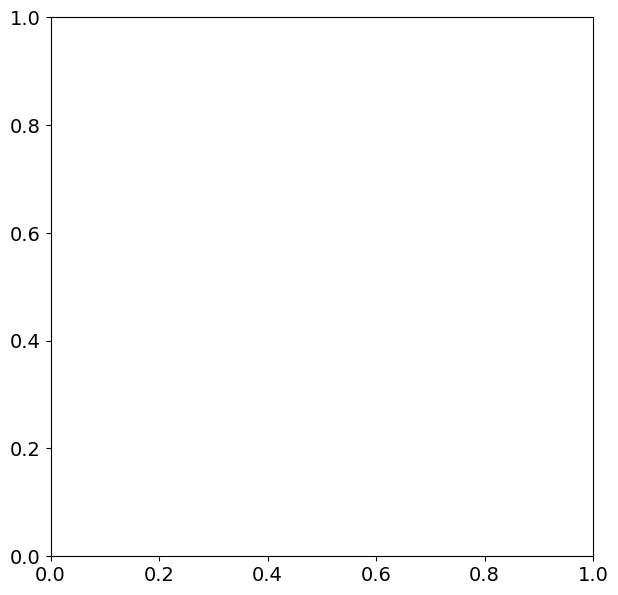

In [9]:
plt.figure(figsize=(7, 7))
y1 = [max(abs(np.array(trace_neu_v[i][3])/1.0661514487245143e-05)) for i in range(len(trace_neu_v)-3)]
x1 = [max(abs(np.array(trace_neu_h[i][3])/1.0661514487245143e-05)) for i in range(len(trace_neu_h))]

y2 = [max(abs(np.array(trace_mm_v[i][3])/1.0661514487245143e-05)) for i in range(len(trace_mm_v)-54)]
x2 = [max(abs(np.array(trace_mm_h[i][3])/1.0661514487245143e-05)) for i in range(len(trace_mm_h))]
plt.plot(x1, y1, "o", label="Vpol neutrino", alpha=0.3)
plt.plot(x2, y2, "o", label="Vpol monopoles", alpha=0.3)
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="both")
plt.xlabel("max Hpol SNR")
plt.ylabel("max Vpol SNR")
plt.title("E = 1e20 eV")
plt.legend()
plt.show()


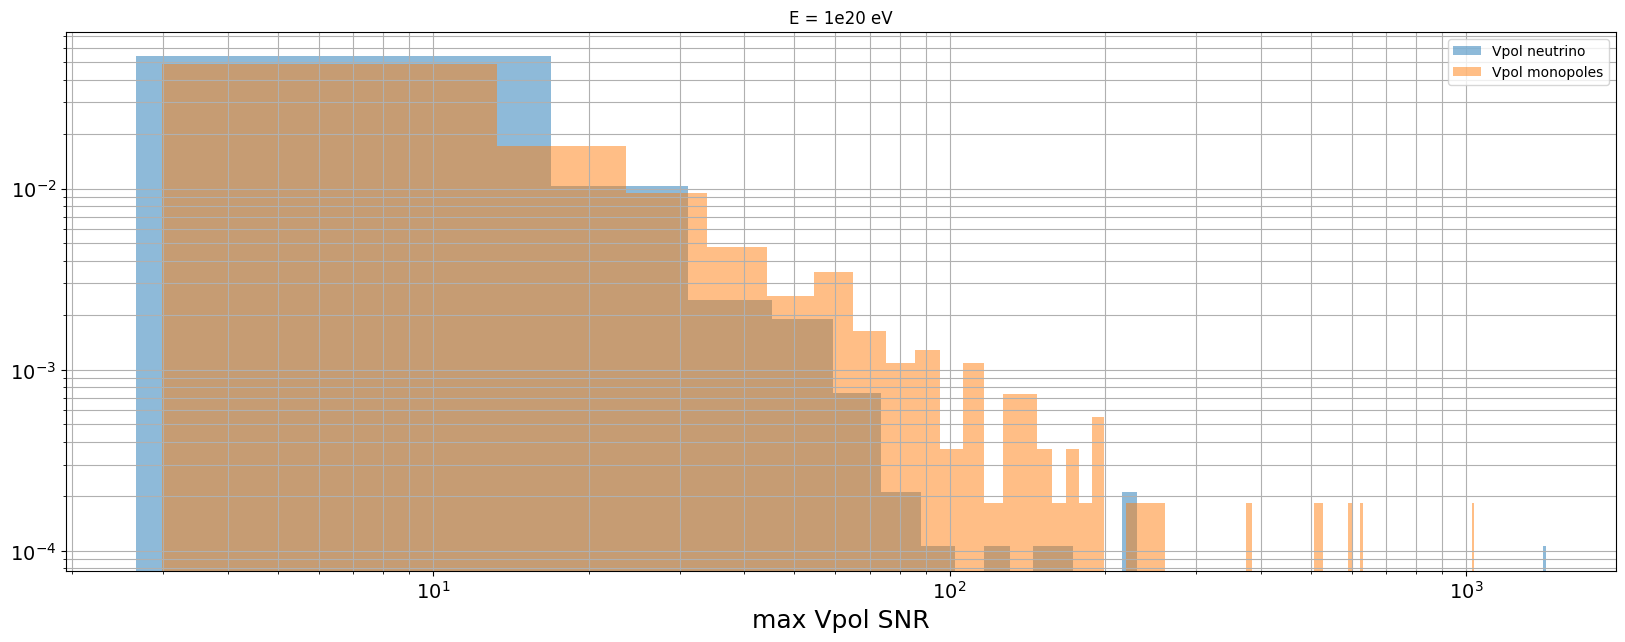

In [10]:
plt.figure(figsize=(20, 7))
y1 = [max(abs(np.array(trace_neu_v[i][3])/1.0661514487245143e-05)) for i in range(len(trace_neu_v)-1)]
#x1 = [max(abs(np.array(trace_neu_h[i][3])/1.0661514487245143e-05)) for i in range(len(trace_neu_h))]

y2 = [max(abs(np.array(trace_mm_v[i][3])/1.0661514487245143e-05)) for i in range(len(trace_mm_v)-1)]
#x2 = [max(abs(np.array(trace_mm_h[i][3])/1.0661514487245143e-05)) for i in range(len(trace_mm_h))]
plt.hist(y1, bins=100, label="Vpol neutrino", density= True, alpha=0.5)
plt.hist(y2, bins=100, label="Vpol monopoles", density=True, alpha=0.5)
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="both")
#plt.xlabel("max Hpol SNR")
plt.xlabel("max Vpol SNR")
plt.title("E = 1e20 eV")
plt.legend()
plt.show()


2.6648454908868557

In [11]:
E = 18
data_mm = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
data_neu = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e04_1e{E}.csv'
data_noise = PATH + f'Peak_data/Data_noise_ara2.csv'
################################
trace_neu_v, trace_mm_v, trace_noise_v = get_trace_from_data(data_neu, data_mm, data_noise, v_pole_channel_info)
trace_neu_h, trace_mm_h, trace_noise_h = get_trace_from_data(data_neu, data_mm, data_noise, h_pole_channel_info)
event_neu, rpr_neu, corr_neu = get_correlation_between_channel(trace_neu_v, trace_neu_v)
event_mm, rpr_mm, corr_mm = get_correlation_between_channel(trace_mm_v, trace_mm_v)
EVENT_mm, mean_CORR_mm, err_CORR_mm, mean_RPR_mm, err_RPR_mm = get_mean_error(event_mm, rpr_mm, corr_mm)
EVENT_neu, mean_CORR_neu, err_CORR_neu, mean_RPR_neu, err_RPR_neu = get_mean_error(event_neu, rpr_neu, corr_neu)
################################

#make color plot:
Eff_mm = []
Eff_neu = []
threshold_rpr = np.arange(0, 10, 0.01)
threshold_corr = np.arange(0, 0.2, 0.005)
for t_corr in threshold_corr:
    for t_rpr in threshold_rpr:   
        ################################
        eff_mm = get_efficiency(event_mm, corr_mm, rpr_mm, t_rpr, t_corr)
        eff_neu = get_efficiency(event_neu, corr_neu, rpr_neu, t_rpr, t_corr)
        ################################
        Eff_mm.append(eff_mm)
        Eff_neu.append(eff_neu)
Eff_mm = np.array(Eff_mm)
Eff_neu = np.array(Eff_neu)
Eff_mm = Eff_mm.reshape(len(threshold_corr), len(threshold_rpr))
Eff_neu = Eff_neu.reshape(len(threshold_corr), len(threshold_rpr))
Eff_mm = np.transpose(Eff_mm)
Eff_neu = np.transpose(Eff_neu)
Eff_mm = np.flipud(Eff_mm)
Eff_neu = np.flipud(Eff_neu)



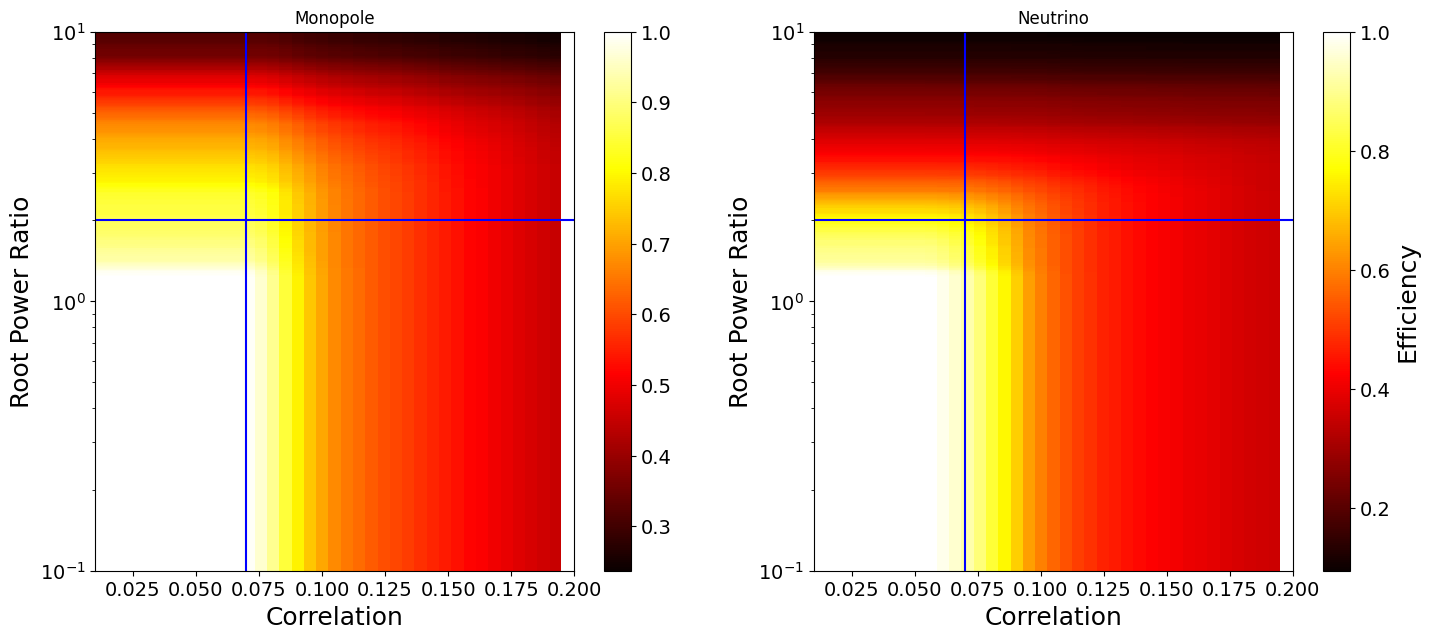

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
im = axs[0].imshow(Eff_mm, cmap='hot', interpolation='nearest', extent=[threshold_corr[0], threshold_corr[-1], threshold_rpr[0], threshold_rpr[-1]], aspect='auto')
axs[0].set_title('Monopole')
axs[0].set_xlabel('Correlation')
axs[0].set_ylabel('Root Power Ratio')
axs[0].set_yscale('log')
axs[0].set_xlim(0.01, 0.2)
axs[0].set_ylim(10, 0.1)
axs[0].invert_yaxis()
axs[0].hlines(2, 0, 0.5, color='b')
axs[0].vlines(0.07, 0, 10, color='b')

fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(Eff_neu, cmap='hot', interpolation='nearest', extent=[threshold_corr[0], threshold_corr[-1], threshold_rpr[0], threshold_rpr[-1]], aspect='auto')
axs[1].set_title('Neutrino')
axs[1].set_xlabel('Correlation')
axs[1].set_ylabel('Root Power Ratio')
axs[1].set_yscale('log')
axs[1].set_xlim(0.01, 0.2)
axs[1].set_ylim(10, 0.1)
axs[1].invert_yaxis()
axs[1].hlines(2, 0, 0.5, color='b')
axs[1].vlines(0.07, 0, 10, color='b')
fig.colorbar(im, ax=axs[1], label = "Efficiency")
plt.show()

In [2]:
# data in csv file:
file_a = "/home/teikiet/Data/a.root"    
file_8074 = "/home/teikiet/Data/fBC_TGraphs_run8074.root"
file_A3 = "/home/teikiet/Data/fBC_TGraphs_A3.root"
#file = "/home/teikiet/Data/grA_ev1_A4_2018_ie0_4096_T26Mar23-131515.979900_run4402.root"
v_pole_channel_name_a, h_pole_channel_name_a = get_channel_name(file_a)
v_pole_channel_name_8074, h_pole_channel_name_8074 = get_channel_name(file_8074)
#v_pole_channel_name_A3, h_pole_channel_name_A3 = get_channel_name(file_A3)
################################
data_a = get_trace_from_root(file_a, v_pole_channel_name_a)
data_8074 = get_trace_from_root(file_8074, v_pole_channel_name_8074)
#data_A3 = get_trace_from_root(file_A3, v_pole_channel_name_A3)
################################
event_a, rpr_a, corr_a = get_correlation_between_channel(data_a, data_a)
event_8074, rpr_8074, corr_8074 = get_correlation_between_channel(data_8074, data_8074)
#event_A3, rpr_A3, corr_A3 = get_correlation_between_channel(data_A3, data_A3)
################################
EVENT_a, mean_CORR_a, err_CORR_a, mean_RPR_a, err_RPR_a = get_mean_error(event_a, rpr_a, corr_a)
EVENT_8074, mean_CORR_8074, err_CORR_8074, mean_RPR_8074, err_RPR_8074 = get_mean_error(event_8074, rpr_8074, corr_8074)
#EVENT_A3, mean_CORR_A3, err_CORR_A3, mean_RPR_A3, err_RPR_A3 = get_mean_error(event_A3, rpr_A3, corr_A3)
################################

In [3]:
#Save data to csv file:
data = np.array([EVENT_a, mean_CORR_a, err_CORR_a, mean_RPR_a, err_RPR_a])
data = np.transpose(data)
df = pd.DataFrame(data, columns=["event", "mean_CORR", "err_CORR", "mean_RPR", "err_RPR"])
df.to_csv("data_a.csv", index=False)

data = np.array([EVENT_8074, mean_CORR_8074, err_CORR_8074, mean_RPR_8074, err_RPR_8074])
data = np.transpose(data)
df = pd.DataFrame(data, columns=["event", "mean_CORR", "err_CORR", "mean_RPR", "err_RPR"])
df.to_csv("data_8074.csv", index=False)

In [26]:
# data in csv file:
Energy_name = [18]
Energy = [10**E for E in Energy_name]
Eff_mm = []
Eff_neu = []
Eff_noise = []
threshold_rpr = 2
threshold_corr = 0.07
for E in Energy_name:
    data_mm = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
    data_neu = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e04_1e{E}.csv'
    data_noise = PATH + f'Peak_data/Data_noise_ara2.csv'
    ################################
    trace_neu_v, trace_mm_v, trace_noise_v = get_trace_from_data(data_neu, data_mm, data_noise, v_pole_channel_info)
    trace_neu_h, trace_mm_h, trace_noise_h = get_trace_from_data(data_neu, data_mm, data_noise, h_pole_channel_info)
    ################################
    event_neu, rpr_neu, corr_neu = get_correlation_between_channel(trace_neu_v, trace_neu_v)
    event_mm, rpr_mm, corr_mm = get_correlation_between_channel(trace_mm_v, trace_mm_v)
    event_noise, rpr_noise, corr_noise = get_correlation_between_channel(trace_noise_v, trace_noise_v)
    ################################
    EVENT_mm, mean_CORR_mm, err_CORR_mm, mean_RPR_mm, err_RPR_mm = get_mean_error(event_mm, rpr_mm, corr_mm)
    EVENT_neu, mean_CORR_neu, err_CORR_neu, mean_RPR_neu, err_RPR_neu = get_mean_error(event_neu, rpr_neu, corr_neu)
    EVENT_noise, mean_CORR_noise, err_CORR_noise, mean_RPR_noise, err_RPR_noise = get_mean_error(event_noise, rpr_noise, corr_noise)
    ################################
    eff_mm = get_efficiency(event_mm, corr_mm, rpr_mm, threshold_rpr, threshold_corr)
    eff_neu = get_efficiency(event_neu, corr_neu, rpr_neu, threshold_rpr, threshold_corr)
    eff_noise = get_efficiency(event_noise, corr_noise, rpr_noise, threshold_rpr, threshold_corr)
    ################################
    Eff_mm.append(eff_mm)
    Eff_neu.append(eff_neu)
    Eff_noise.append(eff_noise)



In [13]:
#get data from csv file:
data_a = pd.read_csv("data_a.csv")
data_8074 = pd.read_csv("data_8074.csv")

EVENT_a = np.array(data_a["event"])
mean_CORR_a = np.array(data_a["mean_CORR"])
err_CORR_a = np.array(data_a["err_CORR"])
mean_RPR_a = np.array(data_a["mean_RPR"])
err_RPR_a = np.array(data_a["err_RPR"])

EVENT_8074 = np.array(data_8074["event"])
mean_CORR_8074 = np.array(data_8074["mean_CORR"])
err_CORR_8074 = np.array(data_8074["err_CORR"])
mean_RPR_8074 = np.array(data_8074["mean_RPR"])
err_RPR_8074 = np.array(data_8074["err_RPR"])



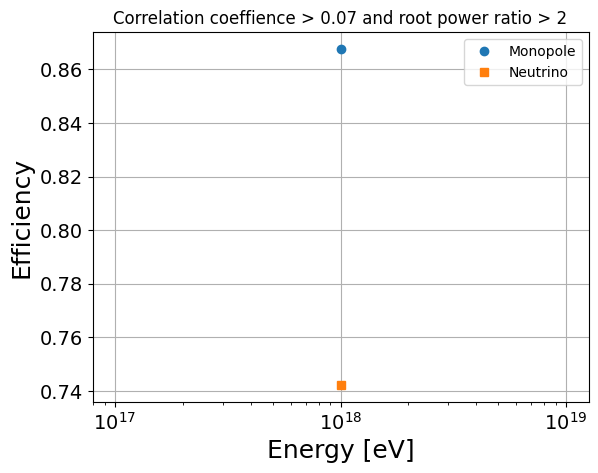

In [27]:
#Energy efficiency for monopole and neutrino
plt.plot(Energy, Eff_mm, "o", label = "Monopole")
plt.plot(Energy, Eff_neu,'s', label = "Neutrino")
plt.xlabel("Energy [eV]")
plt.ylabel("Efficiency")
plt.title(f"Correlation coeffience > {threshold_corr} and root power ratio > {threshold_rpr}")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

NameError: name 'mean_RPR_noise' is not defined

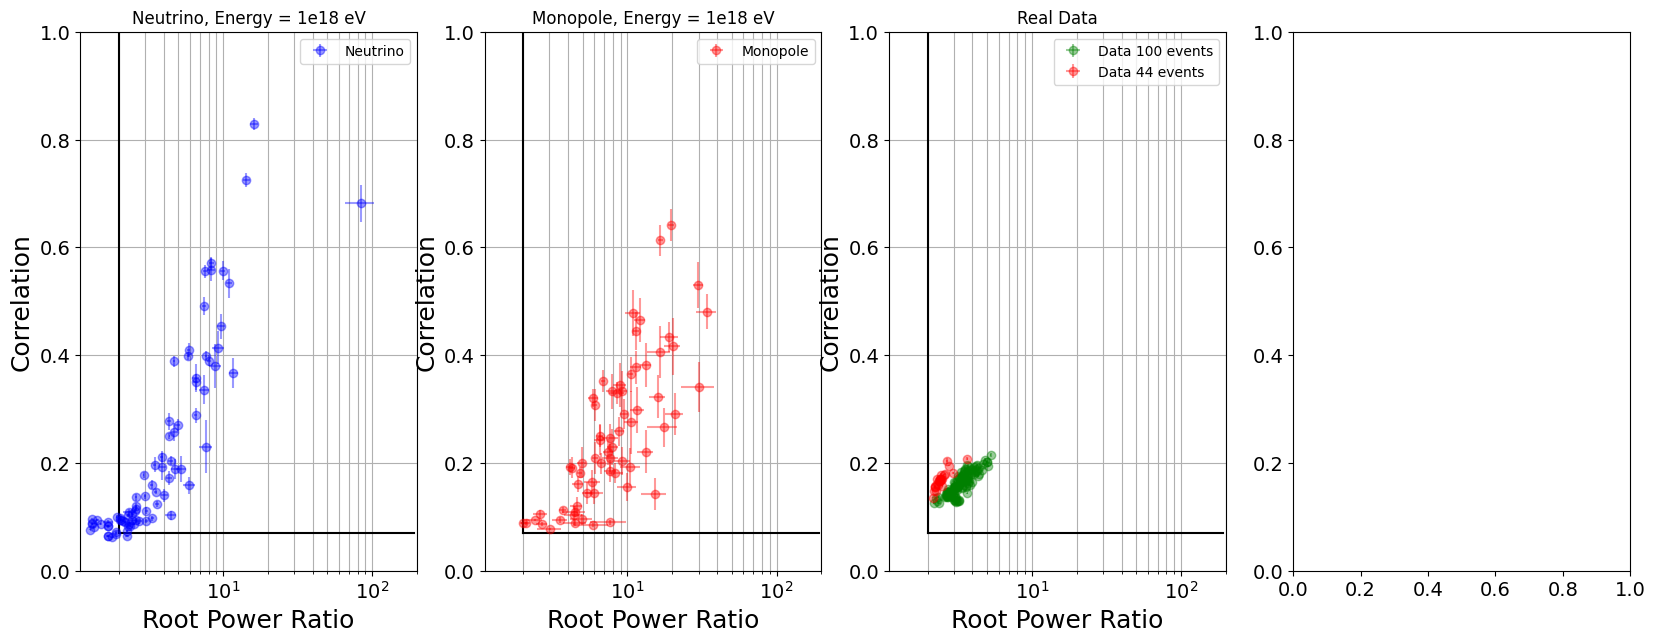

In [17]:
#make 2 side by side plots:
threshold_corr = 0.07
threshold_rpr = 2
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
x = np.arange(threshold_rpr, 200, 10)
axs[0].errorbar(mean_RPR_neu, mean_CORR_neu, xerr=err_RPR_neu, yerr=err_CORR_neu, color = "blue", fmt='o', label='Neutrino', alpha = 0.4)
axs[0].set_title('Neutrino, Energy = 1e18 eV')
axs[0].set_xlabel('Root Power Ratio')
axs[0].set_ylabel('Correlation')
axs[0].set_xscale('log')
axs[0].set_xlim(1.1, 200)
axs[0].set_ylim(0, 1)
axs[0].axvline(x = threshold_rpr, ymin = threshold_corr, color = 'black', linestyle = '-')
axs[0].plot(x, x*0 + threshold_corr, color = 'black')
axs[0].legend()
axs[0].grid(True, which="both")


axs[1].errorbar(mean_RPR_mm, mean_CORR_mm, xerr=err_RPR_mm, yerr=err_CORR_mm, color = "red", fmt='o', label='Monopole', alpha = 0.4)
axs[1].set_xlabel('Root Power Ratio')
axs[1].set_ylabel('Correlation')
axs[1].set_title('Monopole, Energy = 1e18 eV')
axs[1].set_xscale('log')
axs[1].set_xlim(1.1, 200)
axs[1].set_ylim(0, 1)
axs[1].axvline(x = threshold_rpr, ymin = threshold_corr, color = 'black', linestyle = '-')
axs[1].plot(x, x*0 + threshold_corr, color = 'black')
axs[1].legend()
axs[1].grid(True, which="both")



axs[2].errorbar(mean_RPR_a, mean_CORR_a, xerr=err_RPR_a, yerr=err_CORR_a, color = "green", fmt='o', label='Data 100 events', alpha = 0.4)
axs[2].errorbar(mean_RPR_8074, mean_CORR_8074, xerr=err_RPR_8074, yerr=err_CORR_8074, color = "red", fmt='o', label='Data 44 events', alpha = 0.4)
#axs[2].errorbar(mean_RPR_A3, mean_CORR_A3, xerr=err_RPR_A3, yerr=err_CORR_A3, color = "blue", fmt='o', label='Data A3', alpha = 0.4)
axs[2].set_xlabel('Root Power Ratio')
axs[2].set_ylabel('Correlation')
axs[2].set_title('Real Data')
axs[2].set_xscale('log')
axs[2].set_xlim(1.1, 200)
axs[2].set_ylim(0, 1)
axs[2].axvline(x = threshold_rpr,ymin = threshold_corr, color = 'black', linestyle = '-')
axs[2].plot(x, x*0 + threshold_corr, color = 'black')
axs[2].legend()
axs[2].grid(True, which="both")

axs[3].errorbar(mean_RPR_noise, mean_CORR_noise, xerr=err_RPR_noise, yerr=err_CORR_noise, color = "green", fmt='o', label='Noise', alpha = 0.4)
axs[3].set_xlabel('Root Power Ratio')
axs[3].set_ylabel('Correlation')
axs[3].set_title('Noise')
axs[3].set_xscale('log')
axs[3].set_xlim(1.1, 200)
axs[3].set_ylim(0, 1)
axs[3].axvline(x = threshold_rpr, ymin = threshold_corr, color = 'black', linestyle = '-')
axs[3].plot(x, x*0 + threshold_corr, color = 'black')
axs[3].legend()
axs[3].grid(True, which="both")
plt.show()




In [10]:
EVENT_neu

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

In [11]:
eff_mm, eff_neu

(0.945583926329008, 0.8836670651524208)

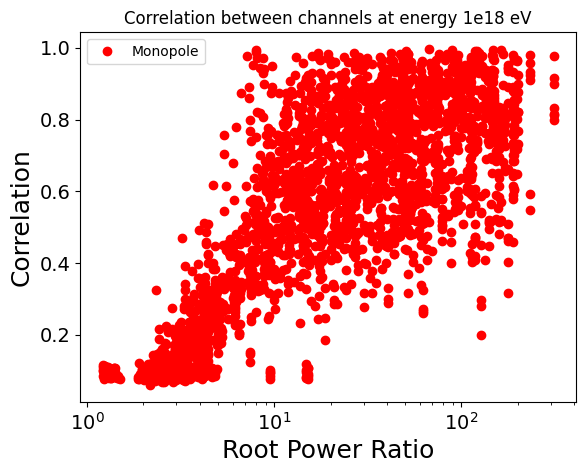

In [12]:
#plt.plot(rpr_neu, corr_neu, color="blue", marker='o', linestyle='None', label="Neutrino")
plt.plot(rpr_mm, corr_mm, color="red", marker='o', linestyle='None', label="Monopole")
plt.xscale('log')
plt.xlabel("Root Power Ratio")
plt.ylabel("Correlation")
plt.legend()
plt.title("Correlation between channels at energy 1e18 eV")
plt.show()

In [13]:
# data in csv file:
from scipy import stats
Energy_name = [18, 19, 20]

MEAN_mm2_neu1_v = []
STD_mm2_neu1_v = []
ERR_mm2_neu1_v = []

MEAN_mm3_neu1_v = []
STD_mm3_neu1_v = []
ERR_mm3_neu1_v = []

MEAN_mm1_neu1_v = []
STD_mm1_neu1_v = []
ERR_mm1_neu1_v = []

MEAN_mn_neu_v = []
STD_mn_neu_v = []
ERR_mn_neu_v = []

MEAN_mm2_neu_v = []
STD_mm2_neu_v = []
ERR_mm2_neu_v = []

MEAN_mm1_neu_v = []
STD_mm1_neu_v = []
ERR_mm1_neu_v = []

MEAN_mm_mm_v = []
STD_mm_mm_v = []
ERR_mm_mm_v = []

MEAN_mm2_noise_v = []
STD_mm2_noise_v = []
ERR_mm2_noise_v = []

MEAN_mm1_noise_v = []
STD_mm1_noise_v = []
ERR_mm1_noise_v = []

for E in Energy_name:
    data_mm = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
    data_neu = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e03_1e{E}.csv'
    data_noise = PATH + f'Peak_data/Data_noise_ara2.csv'
    trace_neu_v, trace_mm_v, trace_noise_v = get_trace_from_data(data_neu, data_mm, data_noise, v_pole_channel_info)
    trace_neu_h, trace_mm_h, trace_noise_h = get_trace_from_data(data_neu, data_mm, data_noise, h_pole_channel_info)

    #Get mean and std:
    mm2_neu1_v = get_pair_correlation(trace_mm_v, trace_neu_v, [2], [1]) #2peaks mm, 1peak neu
    mean_mm2_neu1_v, std_mm2_neu1_v, err_mm2_neu1_v = np.mean(mm2_neu1_v), np.std(mm2_neu1_v), stats.sem(mm2_neu1_v)
    MEAN_mm2_neu1_v.append(mean_mm2_neu1_v)
    STD_mm2_neu1_v.append(std_mm2_neu1_v)
    ERR_mm2_neu1_v.append(err_mm2_neu1_v)

    mm3_neu1_v = get_pair_correlation(trace_mm_v, trace_neu_v, [3], [1]) #3peaks mm, 1peak neu
    mean_mm3_neu1_v, std_mm3_neu1_v, err_mm3_neu1_v = np.mean(mm3_neu1_v), np.std(mm3_neu1_v), stats.sem(mm3_neu1_v)
    MEAN_mm3_neu1_v.append(mean_mm3_neu1_v)
    STD_mm3_neu1_v.append(std_mm3_neu1_v)
    ERR_mm3_neu1_v.append(err_mm3_neu1_v)

    mm1_neu1_v = get_pair_correlation(trace_mm_v, trace_neu_v, [1], [1]) #1peaks mm, 1peak neu
    mean_mm1_neu1_v, std_mm1_neu1_v, err_mm1_neu1_v = np.mean(mm1_neu1_v), np.std(mm1_neu1_v), stats.sem(mm1_neu1_v)
    MEAN_mm1_neu1_v.append(mean_mm1_neu1_v)
    STD_mm1_neu1_v.append(std_mm1_neu1_v)
    ERR_mm1_neu1_v.append(err_mm1_neu1_v)
    
"""
 mn_neu_v = get_pair_correlation(trace_mm_v, trace_neu_v, get_list_peak(trace_mm_v), get_list_peak(trace_neu_v)) # all peaks
    mean_mn_neu_v, std_mn_neu_v, err_mn_neu_v = np.mean(mn_neu_v), np.std(mn_neu_v), stats.sem(mn_neu_v)
    MEAN_mn_neu_v.append(mean_mn_neu_v)
    STD_mn_neu_v.append(std_mn_neu_v)
    ERR_mn_neu_v.append(err_mn_neu_v)

    mm2_neu_v = get_pair_correlation(trace_mm_v, trace_neu_v, [2], get_list_peak(trace_neu_v)) #2peaks mm, all peaks neu
    mean_mm2_neu_v, std_mm2_neu_v, err_mm2_neu_v = np.mean(mm2_neu_v), np.std(mm2_neu_v), stats.sem(mm2_neu_v)
    MEAN_mm2_neu_v.append(mean_mm2_neu_v)
    STD_mm2_neu_v.append(std_mm2_neu_v)
    ERR_mm2_neu_v.append(err_mm2_neu_v)

    mm1_neu_v = get_pair_correlation(trace_mm_v, trace_neu_v, [1], get_list_peak(trace_neu_v)) #1peaks mm, all peaks neu
    mean_mm1_neu_v, std_mm1_neu_v, err_mm1_neu_v = np.mean(mm1_neu_v), np.std(mm1_neu_v),  stats.sem(mm1_neu_v)
    MEAN_mm1_neu_v.append(mean_mm1_neu_v)
    STD_mm1_neu_v.append(std_mm1_neu_v)
    ERR_mm1_neu_v.append(err_mm1_neu_v)

    mm_mm_v = get_pair_correlation(trace_mm_v, trace_mm_v, get_list_peak(trace_mm_v), get_list_peak(trace_mm_v)) #all peaks mm, all peaks mm
    mean_mm_mm_v, std_mm_mm_v, err_mm_mm_v = np.mean(mm_mm_v), np.std(mm_mm_v), stats.sem(mm_mm_v)
    MEAN_mm_mm_v.append(mean_mm_mm_v)
    STD_mm_mm_v.append(std_mm_mm_v)
    ERR_mm_mm_v.append(err_mm_mm_v)
"""
""" mm2_noise_v = get_pair_correlation(trace_mm_v, trace_noise_v, [2], get_list_peak(trace_noise_v)) #2peaks mm, all noise
    mean_mm2_noise_v, std_mm2_noise_v, err_mm2_noise_v = np.mean(mm2_noise_v), np.std(mm2_noise_v), stats.sem(mm2_noise_v)
    MEAN_mm2_noise_v.append(mean_mm2_noise_v)
    STD_mm2_noise_v.append(std_mm2_noise_v)
    ERR_mm2_noise_v.append(err_mm2_noise_v)

    mm1_noise_v = get_pair_correlation(trace_mm_v, trace_noise_v, [1], get_list_peak(trace_noise_v)) #1peaks mm, all noise
    mean_mm1_noise_v, std_mm1_noise_v, err_mm1_noise_v = np.mean(mm1_noise_v), np.std(mm1_noise_v), stats.sem(mm1_noise_v)
    MEAN_mm1_noise_v.append(mean_mm1_noise_v)
    STD_mm1_noise_v.append(std_mm1_noise_v)
    ERR_mm1_noise_v.append(err_mm1_noise_v)
"""
    


' mm2_noise_v = get_pair_correlation(trace_mm_v, trace_noise_v, [2], get_list_peak(trace_noise_v)) #2peaks mm, all noise\n    mean_mm2_noise_v, std_mm2_noise_v, err_mm2_noise_v = np.mean(mm2_noise_v), np.std(mm2_noise_v), stats.sem(mm2_noise_v)\n    MEAN_mm2_noise_v.append(mean_mm2_noise_v)\n    STD_mm2_noise_v.append(std_mm2_noise_v)\n    ERR_mm2_noise_v.append(err_mm2_noise_v)\n\n    mm1_noise_v = get_pair_correlation(trace_mm_v, trace_noise_v, [1], get_list_peak(trace_noise_v)) #1peaks mm, all noise\n    mean_mm1_noise_v, std_mm1_noise_v, err_mm1_noise_v = np.mean(mm1_noise_v), np.std(mm1_noise_v), stats.sem(mm1_noise_v)\n    MEAN_mm1_noise_v.append(mean_mm1_noise_v)\n    STD_mm1_noise_v.append(std_mm1_noise_v)\n    ERR_mm1_noise_v.append(err_mm1_noise_v)\n'

In [14]:
E = np.array([1e18, 1e19, 1e20])

Text(0.5, 1.0, 'Correlation coefficient between neutrino and monopole waveforms with 5 sigma threshold')

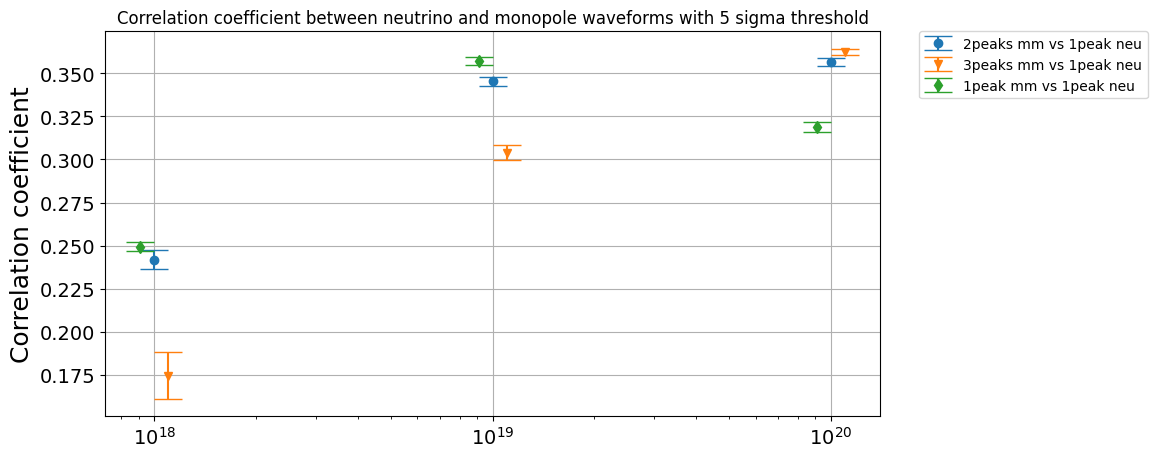

In [15]:
plt.figure(figsize=(10,5))
plt.errorbar(E , MEAN_mm2_neu1_v,  yerr=ERR_mm2_neu1_v, fmt='o', capsize= 10, label="2peaks mm vs 1peak neu")
plt.errorbar(E*1.1, MEAN_mm3_neu1_v,  yerr=ERR_mm3_neu1_v, fmt='v', capsize= 10, label="3peaks mm vs 1peak neu")
plt.errorbar(E/1.1, MEAN_mm1_neu1_v,  yerr=ERR_mm1_neu1_v, fmt='d', capsize= 10, label="1peak mm vs 1peak neu")
#plt.errorbar(E/1.1, MEAN_mm2_neu_v,  yerr=ERR_mm2_neu_v, fmt='d', capsize= 10, label="2peaks mm vs all peaks neu")
#plt.errorbar(E*1.2, MEAN_mm1_neu_v,  yerr=ERR_mm1_neu_v, fmt='D', capsize= 10, label="1peak mm vs all peaks neu")
#plt.errorbar(E*1.1, MEAN_mn_neu_v,  yerr=ERR_mn_neu_v, fmt='s', capsize= 10, label="all peaks mm vs all peaks neu")
#plt.errorbar(E/1.2, MEAN_mm_mm_v,  yerr=ERR_mm_mm_v, fmt='X', capsize= 10, label="all peaks mm vs all peaks mm")
#plt.errorbar(E*1, MEAN_mm2_noise_v,  yerr=ERR_mm2_noise_v, fmt='^', capsize= 10, label="2peaks mm vs noise")
#plt.errorbar(E/1, MEAN_mm1_noise_v,  yerr=ERR_mm1_noise_v, fmt='*', capsize= 10, label="1peaks mm vs noise")
#plt.xlabel("Energy (eV)")
plt.ylabel("Correlation coefficient")
plt.grid()
plt.xscale("log")
#plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Correlation coefficient between neutrino and monopole waveforms with {threshold} sigma threshold".format(threshold=5))


Text(0.5, 0, 'Sigma')

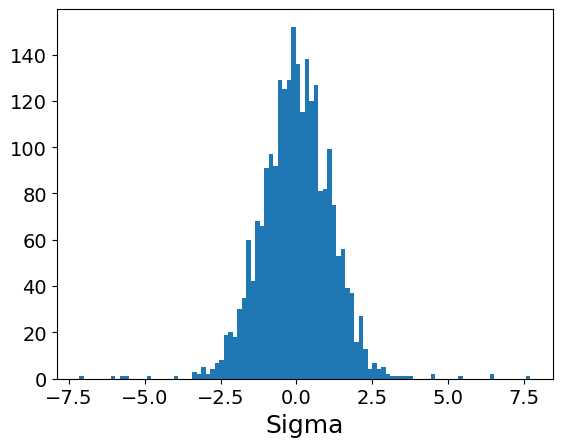

In [16]:
plt.hist((np.array(trace_mm_v[1][3])/1.0661514487245143e-05), bins=100)
plt.xlabel("Sigma")

In [17]:
#V_pole channel:
import numpy as np
import matplotlib.pyplot as plt

# Data for histograms

def plot_corr(data1, data2, data3, data4, data5, data6, name):
    # Create a figure and set up subplots
    bin_edges = 100
    # Plot the first histogram with log scale on y-axis
    #h1 = np.histogram(data1, bins=bin_edges, density=True)

    #h2 = np.histogram(data2, bins=bin_edges,  density=True)

    h3 = np.histogram(data3, bins=bin_edges,   density=True)

    #h4 = np.histogram(data4, bins=bin_edges,   density=True)

    #h5 = np.histogram(data5, bins=bin_edges,   density=True)

    #h6 = np.histogram(data6, bins=bin_edges, density=True)
    
    # Add labels and title to the figure
    #plt.yscale('log')
    # Show the plot
    #plt.figure(figsize=(15, 3))
    #plt.errorbar(h1[1][:-1], h1[0], fmt='-', color='blue', capsize=2, label='neutrinos to neutrinos ')
    #plt.errorbar(h2[1][:-1], h2[0], fmt='-', color='red', capsize=2 , label='monopoles to monopoles')
    plt.errorbar(h3[1][:-1], h3[0], fmt='-', capsize=2 , label=f'monopoles to neutrinos: {name}')
    #plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='green', capsize=2 , label='noise to noise')

    #plt.yscale('symlog')
    #plt.xscale('log')
    plt.grid()  
    plt.legend(loc='upper right')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Density distribution')
    plt.title(f'Density distribution of correlation between waveforms of {name} at E = 1e{E} EeV')
    #plt.show()
"""    plt.figure(figsize=(15, 3))
    plt.errorbar(h4[1][:-1], h4[0], fmt='-', color='blue', capsize=2 , label='Cal Pulser to neutrinos')
    plt.errorbar(h5[1][:-1], h5[0], fmt='-', color='red', capsize=2 , label='Cal Pulser to monopoles')
    plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='black', capsize=2 , label='noise to Cal Pulser')

    plt.yscale('symlog')
    #plt.xscale('log')
    plt.grid()
    plt.legend(loc='upper right')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Density distribution')
    plt.title(f'Density distribution of correlation between waveforms of {name} at E = 1e{E} EeV')
    plt.show()"""


"    plt.figure(figsize=(15, 3))\n    plt.errorbar(h4[1][:-1], h4[0], fmt='-', color='blue', capsize=2 , label='Cal Pulser to neutrinos')\n    plt.errorbar(h5[1][:-1], h5[0], fmt='-', color='red', capsize=2 , label='Cal Pulser to monopoles')\n    plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='black', capsize=2 , label='noise to Cal Pulser')\n\n    plt.yscale('symlog')\n    #plt.xscale('log')\n    plt.grid()\n    plt.legend(loc='upper right')\n    plt.xlabel('Correlation coefficient')\n    plt.ylabel('Density distribution')\n    plt.title(f'Density distribution of correlation between waveforms of {name} at E = 1e{E} EeV')\n    plt.show()"